# Week 5 Programming Assignment 

Remark: 

Please upload your solutions of this assignment to Canvas with a file named "Programming_Assignment_5 _yourname.ipynb" before 11:59pm June 20.

=================================================================================================================

### Problem 1 (4 pts): Use stochastic gradient descent method to train CIFAR10 with ResNet18.

Apply the following two different learning rate schedules respectively

(1) run 120 epochs with a fixed learning rate 0.1,

(2) run 120 epochs, and divide the learning rate by 10 every 30 epochs, which can achieve 94% test accuracy.

and print the results with the following format:

   "Epoch: i, Learning rate: lr$_i$, Training accuracy: $a_i$, Test accuracy: $b_i$"

where $i=1,2,3,...$ means the $i$-th epoch,  $a_i$ and $b_i$ are the training accuracy and test accuracy computed at the end of $i$-th epoch, and lr$_i$ is the learning rate of $i$-th epoch.

Optional Problem: Try to find some other learning rate schedules to achieve $94$% or higher test accuracy with less epochs.

In [ ]:
# 1) The code below solves part 1 of problem 1
# It runs 120 epochs with a fixed learning rate of 0.1

# My code was stopped abruptly because I had left it overnight and because of that only 1 epoch is missing. You can check the code, its similar 
# to the code below this which involves adjusted learning rate where all the 120 epochs are shown along with the time taken to compute also.

# I hope this is not a problem. Its only 1 epoch that is missing. You can confirm the output with the output when adjusted learning rate is used.

import torch
import torch.nn as nn 
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from timeit import default_timer as timer


use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)

class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1:
            self.shortcut = nn.Sequential(nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                                          nn.BatchNorm2d(planes))

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out    


minibatch_size = 128
num_epochs = 120
lr = 0.1

# Step 1: Define a model
my_model = ResNet(BasicBlock, [2,2,2,2], num_classes=10) #ResNet18

if use_cuda:
    my_model = my_model.cuda()

# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)


# Step 3: load dataset
normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))

transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  normalize])

transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size, shuffle=False)

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

start = timer()

#Step 4: Train the NNs
# One epoch is when an entire dataset is passed through the neural network only once.
for epoch in range(num_epochs):
    my_model.train()

    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model(images) 
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters
        
  # Training accuracy
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model(images)
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total

    
    # Test accuracy
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model(images)
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total
        
    print('Epoch: {}, learning rate: {}, the training accuracy: {}, the test accuracy: {}' .format(epoch+1,lr,training_accuracy,test_accuracy)) 

end = timer()
print('Total Computation Time:',end - start)

Use GPU? True
Files already downloaded and verified
Files already downloaded and verified
Epoch: 1, learning rate: 0.1, the training accuracy: 0.40464, the test accuracy: 0.4212
Epoch: 2, learning rate: 0.1, the training accuracy: 0.4826, the test accuracy: 0.4973
Epoch: 3, learning rate: 0.1, the training accuracy: 0.578, the test accuracy: 0.5694
Epoch: 4, learning rate: 0.1, the training accuracy: 0.64666, the test accuracy: 0.6451
Epoch: 5, learning rate: 0.1, the training accuracy: 0.70622, the test accuracy: 0.7161
Epoch: 6, learning rate: 0.1, the training accuracy: 0.71944, the test accuracy: 0.7185
Epoch: 7, learning rate: 0.1, the training accuracy: 0.75256, the test accuracy: 0.745
Epoch: 8, learning rate: 0.1, the training accuracy: 0.74718, the test accuracy: 0.738
Epoch: 9, learning rate: 0.1, the training accuracy: 0.7076, the test accuracy: 0.6977
Epoch: 10, learning rate: 0.1, the training accuracy: 0.7583, the test accuracy: 0.7456
Epoch: 11, learning rate: 0.1, the t

In [ ]:
# 2) The code below solves part 2 of problem 1
# It runs 120 epochs and divides the learning rate by 10 every 30 epochs

import torch
import torch.nn as nn 
import torch.optim as optim
import torchvision
import torch.nn.functional as F
from timeit import default_timer as timer


use_cuda = torch.cuda.is_available()
print('Use GPU?', use_cuda)

class BasicBlock(nn.Module):
    def __init__(self, in_planes, planes, stride):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1:
            self.shortcut = nn.Sequential(nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=False),
                                          nn.BatchNorm2d(planes))

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out    
    
def adjust_learning_rate(optimizer, epoch, init_lr):
    #lr = 1.0 / (epoch + 1)
    lr = init_lr * 0.1 ** (epoch // 30)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

minibatch_size = 128
num_epochs = 120
lr = 0.1

# Step 1: Define a model
my_model = ResNet(BasicBlock, [2,2,2,2], num_classes=10) #ResNet18

if use_cuda:
    my_model = my_model.cuda()

# Step 2: Define a loss function and training algorithm
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(my_model.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)


# Step 3: load dataset
normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))

transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  normalize])

transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])


trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=minibatch_size, shuffle=True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=minibatch_size, shuffle=False)

# classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

start = timer()

#Step 4: Train the NNs
# One epoch is when an entire dataset is passed through the neural network only once.
for epoch in range(num_epochs):
    current_lr = adjust_learning_rate(optimizer, epoch, lr)

    my_model.train()
    for i, (images, labels) in enumerate(trainloader):
        if use_cuda:
          images = images.cuda()
          labels = labels.cuda()

        # Forward pass to get the loss
        outputs = my_model(images) 
        loss = criterion(outputs, labels)
        
        # Backward and compute the gradient
        optimizer.zero_grad()
        loss.backward()  #backpropragation
        optimizer.step() #update the weights/parameters
        
  # Training accuracy
    my_model.eval()
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(trainloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()  
          outputs = my_model(images)
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    training_accuracy = float(correct)/total

    
    # Test accuracy
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(testloader):
        with torch.no_grad():
          if use_cuda:
              images = images.cuda()
              labels = labels.cuda()
          outputs = my_model(images)
          p_max, predicted = torch.max(outputs, 1) 
          total += labels.size(0)
          correct += (predicted == labels).sum()
    test_accuracy = float(correct)/total
        
    print('Epoch: {}, learning rate: {}, the training accuracy: {}, the test accuracy: {}' .format(epoch+1,current_lr,training_accuracy,test_accuracy)) 

end = timer()
print('Total Computation Time:',end - start)

Use GPU? True
Files already downloaded and verified
Files already downloaded and verified
Epoch: 1, learning rate: 0.1, the training accuracy: 0.40408, the test accuracy: 0.4171
Epoch: 2, learning rate: 0.1, the training accuracy: 0.52126, the test accuracy: 0.5238
Epoch: 3, learning rate: 0.1, the training accuracy: 0.60624, the test accuracy: 0.603
Epoch: 4, learning rate: 0.1, the training accuracy: 0.65106, the test accuracy: 0.6437
Epoch: 5, learning rate: 0.1, the training accuracy: 0.72196, the test accuracy: 0.7163
Epoch: 6, learning rate: 0.1, the training accuracy: 0.71686, the test accuracy: 0.7101
Epoch: 7, learning rate: 0.1, the training accuracy: 0.76772, the test accuracy: 0.7695
Epoch: 8, learning rate: 0.1, the training accuracy: 0.75874, the test accuracy: 0.7492
Epoch: 9, learning rate: 0.1, the training accuracy: 0.77858, the test accuracy: 0.7639
Epoch: 10, learning rate: 0.1, the training accuracy: 0.79572, the test accuracy: 0.7849
Epoch: 11, learning rate: 0.1,

### Problem 2 (3 pts):  Consider the possion equation 
\begin{equation}\label{1Dposi}
\left\{
\begin{aligned}
-u''&= f, \,\, 0<x<1, \\
 u(0)&=u(1)=0.
\end{aligned}
\right.
\end{equation}

Assume $f(x)=1$, then the exact solution is $u(x)=\frac{1}{2}x(1-x)$. Given the partition with the grid points 
$x_i=\frac{i}{n+1}, i=0,1,\cdots,n+1$, then by finite element discretization, 
we obtain 

\begin{equation}\label{matrix}
A\ast \mu =b,~~ A=\frac{1}{h}[-1,2,-1].
\end{equation}

Use gradient descent method to solve the above problem with random initial guess $\mu^0$:

$$
\mu^{m} = \mu^{m-1} - \eta ( A* \mu^{m-1}- b),~~ m=1,2,3,...,M
$$

Set $n=15$ and $M=10$.
    
(1) Plot the curves of $u$ and $\mu^{M}$.

(2) Compute the error of the residual by $e^m = \sqrt{\sum_{i=0}^{n+1}|(A* \mu^{m}- b)_i |^2},~~ m=1,2,3,...,M$ and the index $i$ means the $i$-th entry of the vector. Plot a curve, where x-axis is $m=1,2,3,...,M$ and y-axis is $e^m$.

(3) Find the minumum $M$ when  $e^M = \sqrt{\sum_{i=0}^{n+1}|(A* \mu^{M}- b)_i |^2}<10^{-4}$ and record the computational time cost. 

time cost 0.003966093063354492


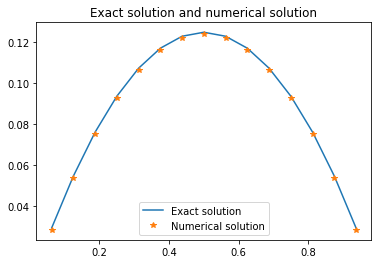

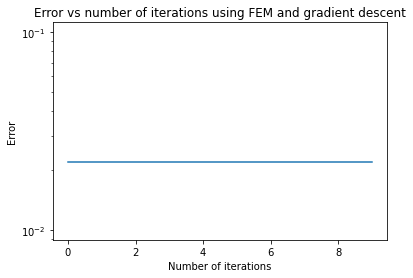

In [34]:
import numpy as np
import time
import matplotlib.pyplot as plt

######## FEM_GD  ########
# Write your code in FEM_GD function to compute one gradient descent iteration
def FEM_GD(u, u1, b, h):
  eta = h/4
  u1 = u - eta * b
  return u1

######## parameter definition ########
J = 4                                # grid level
n = 2**J - 1                         # number of inner grid points
h = 1/ 2**J                          # length of grid interval
x = np.arange(1, n + 1) *h           # grid points
u = 1/2*x*(1-x)                      # true solution at grid points
b = np.ones(n)*h                     # right-hand-size term
u1 = (np.random.rand(n)*2-1+np.sin(4*np.pi*x))/2  # initial value for u
M = 10
t0 = time.time()                     # initial time
A = np.array([-1,2,-1])/h            # Defined A here which is then used in FEM_GD function

######## compute numerical solution ########
err = []                             # create a list to save the error of each iteration
for m in range(M):
  u1 = FEM_GD(u, u1, b, h)
  temp=np.array([u1[0]*A[1]+u1[1]*A[2]])
  for j in np.arange(1,len(u1)-1):
      temp=np.append(temp,np.dot(u1[j-1:j+2],A))
  Au=np.append(temp,u1[-2]*A[0]+u1[-1]*A[1])
  err.append(np.linalg.norm(Au-b))   # compute the error of m-th iteration and save it to the list
print('time cost', time.time() - t0)
######## plot the exact solution and numerical solution ########
plt.figure()
plt.title('Exact solution and numerical solution')
plot = plt.plot(x,u,label='Exact solution')
plot = plt.plot(x,u1,'*',label='Numerical solution')
plt.legend()
plt.show()

######## plot the l2 norm of the error vs iterations ########
plt.figure()
plt.title('Error vs number of iterations using FEM and gradient descent')
plot = plt.plot(err)
plt.xlabel('Number of iterations')
plt.yscale('log')
plt.ylabel('Error')
plt.show()

=================================================================================================================

### Problem 3 (3 pts): Consider the Poisson equation described in Problem 1, call the Multigrid code given in the following cell to obtain a solution $u^{\nu}$.
Use multigrid method to solve the above problem with random initial guess $\mu^0$:

$$
\mu^{m} =  MG1(\mu^{m-1}),~~ m=1,2,3,...,M
$$

Set $n=15$ and $M=10$.
    
(1) Plot the curves of $u$ and $\mu^{M}$ and record the computational time cost.

(2) Compute the error of the residual by $e^m = \sqrt{\sum_{i=0}^{n+1}|(A* \mu^{m}- b)_i |^2},~~ m=1,2,3,...,M$ and the index $i$ means the $i$-th entry of the vector. Plot a curve, where x-axis is $m=1,2,3,...,M$ and y-axis is $e^m$.

time cost 0.01445317268371582


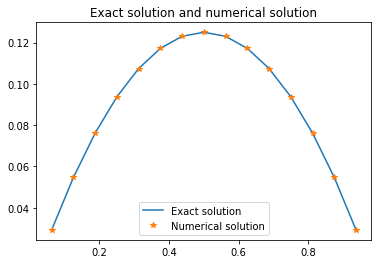

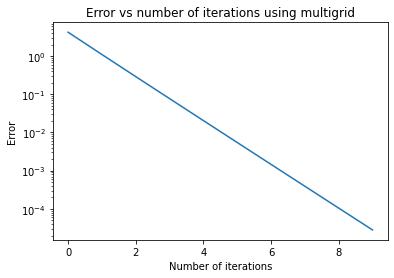

In [12]:
import numpy as np
import time
import matplotlib.pyplot as plt

######## MG1 definition ########
def MG1(b, u0, J, v):  # \mu=[\mu_1,\mu_2,\mu_3,...,\mu_J]
  if len(b)!=len(u0):
    print('input size not equal')
  if len(v)!=J:
    print('length of v not equal to J')
  B=[0,b]
  U=[0,u0]
  R=np.array([1/2,1,1/2])
  for l in np.arange(1,J+1):
    h_l=1/2**(J+1-l)
    A=np.array([-1,2,-1]/h_l)
    if l<J:
      for i in np.arange(0,v[l-1]):
        temp=np.array([U[l][0]*A[1]+U[l][1]*A[2]])
        for j in np.arange(1,len(U[l])-1):
            temp=np.append(temp,np.dot(U[l][j-1:j+2],A))
        temp=np.append(temp,U[l][-2]*A[0]+U[l][-1]*A[1])
        U[l]+=1/4*h_l*(B[l]-temp)
      U.append(np.zeros((len(U[l])-1)//2))
      newb=[]
      temp=np.array([U[l][0]*A[1]+U[l][1]*A[2]])
      for j in np.arange(1,len(U[l])-1):
          temp=np.append(temp,np.dot(U[l][j-1:j+2],A))
      temp=np.append(temp,U[l][-2]*A[0]+U[l][-1]*A[1])
      for k in range((len(U[l])-1)//2):
        newb.append(np.dot((B[l]-temp)[2*k:2*k+3],R))
      B.append(newb)
    else:
      for i in np.arange(0,v[l-1]):
        temp=np.array(U[l][0]*A[1])
        U[l]+=1/4*h_l*(B[l]-temp)

  for l in np.arange(J-1,0,-1):
    temp=[1/2*U[l+1][0]]
    for i in np.arange(1,len(U[l+1])*2):
      if i%2==1:
        temp.append(U[l+1][(i-1)//2])
      else:
        temp.append(1/2*(U[l+1][(i-2)//2]+U[l+1][i//2]))
    temp.append(1/2*U[l+1][-1])
    U[l]+=temp
  return U[1]


######## parameter definition ########
J = 4                                # grid level
n = 2**J - 1                         # number of inner grid points
h = 1/ 2**J                          # length of grid interval
x = np.arange(1, n + 1) *h           # grid points
u = 1/2*x*(1-x)                      # true solution at grid points
b = np.ones(n)*h                     # right-hand-size term
u1 = np.random.rand(n)*2-1           # initial value for u
M = 10
t0 = time.time()
v = [2, 2, 2, 2]

######## compute numerical solution ########
err = []    
for m in range(M):
  u1 = MG1(b, u1, J, v)
  temp=np.array([u1[0]*A[1]+u1[1]*A[2]])
  for j in np.arange(1,len(u1)-1):
      temp=np.append(temp,np.dot(u1[j-1:j+2],A))
  Au=np.append(temp,u1[-2]*A[0]+u1[-1]*A[1])
  err.append(np.linalg.norm(Au-b))   # compute the error of m-th iteration and save it to the list
print('time cost', time.time() - t0)
######## plot the exact solution and numerical solution ########
plt.figure()
plt.title('Exact solution and numerical solution')
plot = plt.plot(x,u,label='Exact solution')
plot = plt.plot(x,u1,'*',label='Numerical solution')
plt.legend()
plt.show()

######## plot the l2 norm of the error vs iterations ########
plt.figure()
plt.title('Error vs number of iterations using multigrid')
plot = plt.plot(err)
plt.xlabel('Number of iterations')
plt.yscale('log')
plt.ylabel('Error')
plt.show()

=================================================================================================================